In [1]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.linalg as linalg
import scipy.spatial as spat
import matplotlib.patches as patches
import matplotlib.colors as colors
from scipy.spatial.distance import cdist
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

Import the usual suspects

In [2]:
PITCH = 4.2
alpha = 10
beta_0 = 1.3182817e+7
coupling = 191

## Building and solving a coupling matrix

We want to solve something of the form 

$i \frac{\partial \phi_n}{\partial z} = C_{m, m+a_1} e^{iA((m + a_1) /2)\cdot a_1} \phi_{m+a_1} +  C_{m, m+a_2} e^{iA((m + a_2) /2)\cdot a_2} \phi_{m+a_2}+  C_{m, m+a_3} e^{iA((m + a_3) /2)\cdot a_3} \phi_{m+a_3} + D_n \phi_n $

The first three terms are the effects due to coupling with neighbours, while the fourth term is the on-site change due to the presence of twist.

First let's define a function that handles the effects of twist

Turning to: Ma X et al. 2011 Angular-momentum coupled optical waves in chirally-coupled-core fibers Opt. Expr. 19

They find: $ \beta_{hel} \approx \beta_{straight} \sqrt{1+\alpha^2 R^2}$ 
if $(\alpha R)^2$ is small we can approximate: $\beta_{hel} \approx \beta_{straight} + \frac{\beta_{straight}}{2}(\alpha R)^2$


In [3]:
def twisted_beta(beta_straight, twist_rate, radial_dist):
    beta_hel = beta_straight*np.sqrt(1+ twist_rate**2 * radial_dist**2)
    # print('Difference due to twist: {:.2f}'.format(beta_hel-beta_straight))
    return beta_hel

vec_twist_beta = np.vectorize(twisted_beta)

In [4]:
def build_honeycomb(n,m, pitch):
    a_1 = np.array([3*pitch/2, np.sqrt(3)*pitch/2])
    a_2 = np.array([3*pitch/2, -np.sqrt(3)*pitch/2])

    coord_list = []
    for j in range(m):
        for i in range(n): 
            coord_list.append(a_1*i + a_2*j)

    coord_list_shifted = coord_list + np.array([-pitch, 0])
    coord_list = np.array(coord_list)
    # print(coord_list_shifted)


    full_coord_list = np.concatenate((coord_list, coord_list_shifted), axis=0)
    centered_coord_list = full_coord_list - (n*a_1 + m*a_2)/2 + np.array([2*pitch,0])

    return centered_coord_list

3200


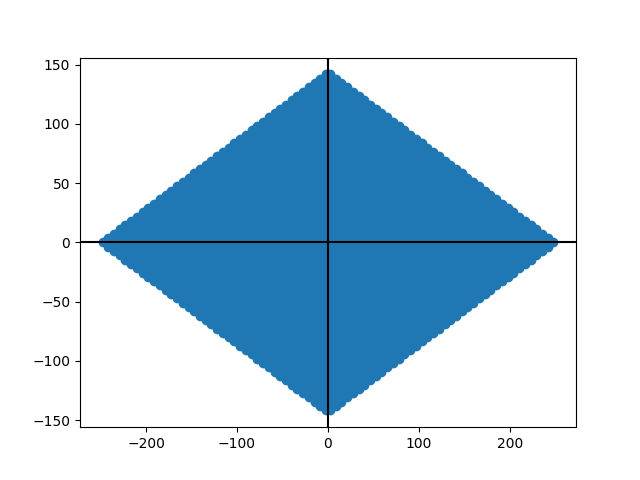

In [5]:
b_10_list = build_honeycomb(40,40, PITCH)
# plt.scatter(b_10_list[:,0], b_10_list[:,1]);   
# plt.scatter(b_10_list[:,0]-11.5*PITCH, b_10_list[:,1]-np.sqrt(3)*PITCH/2); 

plt.axhline(0, color='black')
plt.axvline(0, color='black')



plt.scatter(b_10_list[:,0], b_10_list[:,1]); 
# plt.scatter(b_10_list[:10,0], b_10_list[:10,1]);
# plt.scatter(b_10_list[10,0], b_10_list[10,1]);
# plt.scatter(b_10_list[20,0], b_10_list[20,1]);
print(len(b_10_list))

If we want a deformed lattice we can delete cores using the code below 

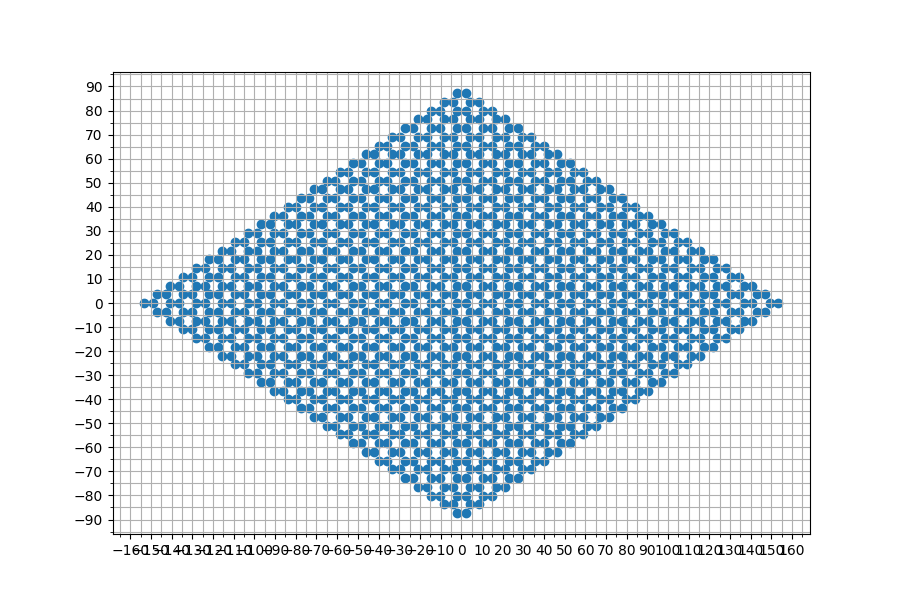

In [6]:
def onclick(event):
    pos.append([event.xdata,event.ydata])

pos = []

fig1 = plt.figure(figsize=(9,6))
ax1 = fig1.add_subplot(111)

ax1.scatter(b_10_list[:,0], b_10_list[:,1], cmap='Reds')
ax1.xaxis.set_major_locator(MultipleLocator(10))
ax1.xaxis.set_minor_locator(MultipleLocator(5))
ax1.yaxis.set_major_locator(MultipleLocator(10))
ax1.yaxis.set_minor_locator(MultipleLocator(5))
#ax1.xaxis.set_major_formatter({x:.0f})
plt.grid(which='both')

fig1.canvas.mpl_connect('button_press_event', onclick)
plt.show()


In [7]:

pos = np.array(pos)
points_to_keep = np.where(cdist(b_10_list, pos, 'euclidean')>2, False, True )
index_to_keep = np.invert(np.any(points_to_keep, axis=1))
deformed_lattice= b_10_list[index_to_keep]
# [print(type(i)) for i in pos]


ValueError: XB must be a 2-dimensional array.

In [ ]:
plt.scatter(deformed_lattice[:,0], deformed_lattice[:,1]);
plt.axes().set_aspect('equal');
# print(deformed_lattice[50,:])
# points_in_circ = [(x,y) for x,y in zip(deformed_lattice[:,0], deformed_lattice[:,1]) if circ.contains_points]

NameError: name 'deformed_lattice' is not defined

Now we want to read in a geometry from COMSOL and find the nearest neighbours

In [6]:

# coord_data = pd.read_csv('../COMSOL/Data/Honeycomb/honeycomb coord locs small.csv', header=4,float_precision='round_trip')
# # coord_data = pd.read_csv('../COMSOL/Data/Honeycomb/coupled_core_locs.csv', header=4,float_precision='round_trip')

# #display(coord_data.iloc[:,1:])
# x_coords = coord_data.iloc[:,1:128]
# y_coords = coord_data.iloc[:,128:]
# x_coord_np = x_coords.transpose()[0].to_numpy()
# y_coord_np = y_coords.transpose()[0].to_numpy()

# combined_list  = np.transpose(np.array((x_coord_np,y_coord_np)))


def build_onsite(beta_straight, twist, coord_pairs):
    distance_to_each_core = np.array([round(np.sqrt(i**2 + j**2),4) for i,j in coord_pairs])*1e-6

    twist_for_each_core = vec_twist_beta(beta_straight, twist, distance_to_each_core) - beta_straight
    onsite_matrix = np.diag(twist_for_each_core)

    return onsite_matrix

Next we build up the vector potential $\mathbf{A}(\mathbf{r})$

In [7]:
def vec_potential(x,y, twist_rate, beta):
    vec_A = twist_rate*beta*np.array([y,-x])
    return vec_A


draw three equal sections over the lattice

In [8]:

def ABC_sections(x_size):
    xyA = np.array([[0,0], [x_size, -x_size*0.5], [x_size, x_size], [0, x_size]])
    xyC = np.array([[0,0],[x_size,-x_size*0.5],[x_size, -x_size*0.875], [-x_size,-0.875*x_size],[-x_size,-x_size*0.5]])
    xyB = np.array([[0,0], [-x_size, -x_size*0.5], [-x_size, x_size], [0, x_size]])
    shape_A = patches.Polygon(xyA,alpha=0.1, label='A')
    shape_B = patches.Polygon(xyC,fc='red', alpha=0.1, label='C')
    shape_C = patches.Polygon(xyB,fc='green', alpha=0.1, label='B')

    return shape_A, shape_B, shape_C

In [9]:
def index_in_sections(pair_list, sample_width):
    A_shape, B_shape, C_shape, = ABC_sections(sample_width)
    
    fig_for_index = plt.figure(figsize=(9,6))
    ax_for_index = fig_for_index.add_subplot(111)

    ax_for_index.scatter(pair_list[:,0], pair_list[:,1])

    ax_for_index.add_patch(A_shape)
    ax_for_index.add_patch(B_shape)
    ax_for_index.add_patch(C_shape)

    Acont = A_shape.contains_points(ax_for_index.transData.transform(pair_list)).nonzero()[0]
    Bcont = B_shape.contains_points(ax_for_index.transData.transform(pair_list)).nonzero()[0]
    Ccont = C_shape.contains_points(ax_for_index.transData.transform(pair_list)).nonzero()[0]
    # plt.show()

    return Acont, Bcont, Ccont

Finally we stick all of these components into our coupling matrix C

In [10]:
def find_eigvalues(pair_list, pitch, coupling_c, beta_straight, twist, with_onsite=True):
    coupling_matrix = np.zeros((len(pair_list[:,0]),len(pair_list[:,0])),dtype=complex)
    honeycomb_point_tree = spat.cKDTree(pair_list, leafsize=100)
    nearest_neighbour_array = honeycomb_point_tree.query_pairs(pitch+0.001, output_type = 'ndarray')

    for i in nearest_neighbour_array:
        mid_point = (pair_list[i[0]] + pair_list[i[1]])/2
        a_dist = (pair_list[i[0]] - pair_list[i[1]])*1.0e-6
        # print(mid_point)
        vec_term = vec_potential(mid_point[0]*1.0e-6, mid_point[1]*1.0e-6, twist, beta_straight)

        coupling_matrix[i[0],i[1]] = coupling_c* np.exp(1.0j * np.dot(vec_term, a_dist))

        a_dist_rev = (pair_list[i[1]] - pair_list[i[0]])*1.0e-6
        coupling_matrix[i[1],i[0]] = coupling_c* np.exp(1.0j * np.dot(vec_term, a_dist_rev))
    if with_onsite is True:
        onsite_matrix = build_onsite(beta_straight, twist, pair_list)
        full_C = coupling_matrix + onsite_matrix
    else: 
        full_C = coupling_matrix
    # print(np.allclose(full_C, np.transpose(np.conjugate(full_C))))
    beta_super, eigvecs = np.linalg.eigh(full_C)

    return beta_super,eigvecs


In [11]:
diff = b_10_list[2] - b_10_list[0]
print(np.arctan(diff[1]/diff[0]))
print(b_10_list)

0.523598775598299
[[-243.6           0.        ]
 [-237.3           3.6373067 ]
 [-231.            7.27461339]
 ...
 [ 231.           -7.27461339]
 [ 237.3          -3.6373067 ]
 [ 243.6           0.        ]]


In [12]:
def find_eigvalues_haldane(pair_list, pitch, coupling_c1, coupling_c2, M, with_onsite=False):
    coupling_matrix = np.zeros((len(pair_list[:,0]),len(pair_list[:,0])),dtype=np.complex128)
    honeycomb_point_tree = spat.cKDTree(pair_list, leafsize=100)
    next_and_neighbour_array = honeycomb_point_tree.query_pairs(np.sqrt(3)*(pitch+0.001), output_type = 'ndarray')
    nearest_neighbour_array = honeycomb_point_tree.query_pairs(pitch+0.0001, output_type = 'ndarray')
    
    tup_all_list = [(i[0],i[1]) for i in next_and_neighbour_array]
    tup_nn_list = [(i[0],i[1]) for i in nearest_neighbour_array]
    tup_next_n_list = [i for i in tup_all_list if i not in tup_nn_list]

    # print(len(tup_all_list), len(tup_nn_list), len(tup_next_n_list))

    for n in nearest_neighbour_array:
        coupling_matrix[n[0],n[1]] = coupling_c1
        coupling_matrix[n[1],n[0]] = coupling_c1

    for i in tup_next_n_list:
        # print(i[0])
        # print(pair_list[i[0]], pair_list[i[1]])
        if i[0] >= len(pair_list)//2:
            a_or_b = -1
        else:
            a_or_b = 1
        # print(a_or_b)
        vec_between_points = pair_list[i[1]] - pair_list[i[0]]
        if vec_between_points[0] == 0:
            if vec_between_points[1] > 0:
                coupling_i = 1.0j*coupling_c2  
            elif vec_between_points[1] < 0: 
                coupling_i = -1.0j*coupling_c2 
        else:
            angle_between_points = np.arctan(vec_between_points[1]/vec_between_points[0])
            if angle_between_points > 0 and angle_between_points < 4*np.pi/10:
                # print(vec_between_points)
                # if vec_between_points[0] > 0:
                    # print('1')
                coupling_i = -1.0j*coupling_c2 
            elif angle_between_points < 0 and angle_between_points > -4*np.pi/10:            
                # if vec_between_points[0] > 0:
                    # print('3')
                coupling_i = 1.0j*coupling_c2 

        coupling_matrix[i[0],i[1]] = a_or_b*coupling_i
        coupling_matrix[i[1],i[0]] = -a_or_b*coupling_i

                # elif vec_between_points[0] < 0: 
                #     print('4')
                #     coupling_matrix[i[0],i[1]] = 1.0j*coupling_c2 
                #     coupling_matrix[i[1],i[0]] = -1.0j*coupling_c2          
        #     mid_point = (pair_list[i[0]] + pair_list[i[1]])/2
    #     a_dist = (pair_list[i[0]] - pair_list[i[1]])*1.0e-6
    #     # print(mid_point)
    #     vec_term = vec_potential(mid_point[0]*1.0e-6, mid_point[1]*1.0e-6, twist, beta_straight)

        # coupling_matrix[i[0],i[1]] = coupling_c1 #* np.exp(1.0j * np.dot(vec_term, a_dist))

    #     a_dist_rev = (pair_list[i[1]] - pair_list[i[0]])*1.0e-6
        # coupling_matrix[i[1],i[0]] = coupling_c1 #* np.exp(1.0j * np.dot(vec_term, a_dist_rev))
    # if with_onsite is True:
    #     onsite_matrix = build_onsite(beta_straight, twist, pair_list)
    #     full_C = coupling_matrix + onsite_matrix
    # else: 
    #     full_C = coupling_matrix
    # # print(np.allclose(full_C, np.transpose(np.conjugate(full_C))))
    onsite = np.eye(len(pair_list[:,0]),dtype=np.complex128)*M 
    full_matrix = coupling_matrix + onsite
    # display(pd.DataFrame(full_matrix))
    beta_super, eigvecs = np.linalg.eigh(full_matrix)
    # print(next_and_neighbour_array)
    # print(nearest_neighbour_arrary)
    # print(np.shape(next_and_neighbour_array), np.shape(nearest_neighbour_arrary))
    
    # print(np.shape([[i[0],i[1]] for i in next_and_neighbour_array if (i[0],i[1]) in nearest_neighbour_arrary]))
    # for n,i in enumerate(nearest_neighbour_arrary):
    #     print(i)
    #     matches_indices = np.where(i==next_and_neighbour_array)
    #     # print(matches_indices[1])
    #     print(matches_indices[0])
    #     print(next_and_neighbour_array[matches_indices])
    #     print('------')
    #     # for index in matches_indices:
    #         # print(next_and_neighbour_array[index[0],index[1]])
    #     # if i in next_and_neighbour_array:

    #         # print(' in both ')
    return beta_super,eigvecs

In [13]:
# tp_1 = 200
# tp_2 = 10
# test_fig = plt.figure(figsize=(10,6))
# ax_test = test_fig.add_subplot(111)
# ax_test.scatter(b_10_list[tp_1][0],b_10_list[tp_1][1], color='red')
# ax_test.scatter(b_10_list[tp_2][0],b_10_list[tp_2][1], color='blue')
# plt.show()
# print( b_10_list[tp_1], b_10_list[tp_2])
# dpoint = b_10_list[tp_2]-b_10_list[tp_1]
# print(dpoint[0])
# if dpoint[0] == 0.0 and dpoint[1]>0:
#     print('+ pi/2')
# elif dpoint[0] == 0.0 and dpoint[1]<0:
#     print('- pi/2')
# else:
#     print(np.arctan(dpoint[1]/dpoint[0]))

In [14]:
# Plotting betas
def plot_betas(beta_vals, coupling, point_label, xrange=[]):
    fig1  = plt.figure(figsize=(12,12))   
    ax1 = fig1.add_subplot(111)
    if type(beta_vals) == list:
        for i,vals in enumerate(beta_vals):
            ax1.scatter(np.arange(len(vals)), vals, label=point_label[i])

    else: 
        ax1.scatter(np.arange(len(beta_vals)), beta_vals-np.mean(beta_vals), label=point_label)
    ax1.grid(axis='x', which='both')
    ax1.set_ylabel(r'$ \beta/C$')
    ax1.set_xlabel('Mode Index')
    if len(xrange) == 2:
        ax1.set_xlim(xrange[0],xrange[1])
    plt.legend();


In [15]:
# For nice plotting of eigenvectors 
def plot_coloured_chain(intensities, circ_size, circ_locations, label):
    """
    
    """
    fig_chain = plt.figure(figsize=(15,10))
    ax_chain = fig_chain.add_subplot(111)
    intensities = intensities/np.sum(intensities)
    circ_list = []
    norm = colors.Normalize(vmin=min(np.real(intensities)), vmax=max(np.real(intensities)))
    cmap = plt.cm.get_cmap('Reds')
    cmap(norm(np.real(intensities)))

    for j in range(len(intensities)):
        #print(intensities[j])
        circ_list.append(patches.Circle((circ_locations[j][0], circ_locations[j][1]), radius=circ_size//2,
                                            color=cmap(norm(np.real(intensities[j]))),ec='black')) 

#         ax_chain.annotate(str(j), (circ_locations[j][0], circ_locations[j][1]), color='black',
#                           fontsize=10, ha='center', va='center')
   
    plt.axis('off')
    # Plot all circles
    for _circ in circ_list:
        ax_chain.add_patch(_circ)
    plt.title('Mode no. {:d}'.format(label), loc='left')
    plt.axis('scaled')
    plt.show()     
    return 

Calculate local Chern number

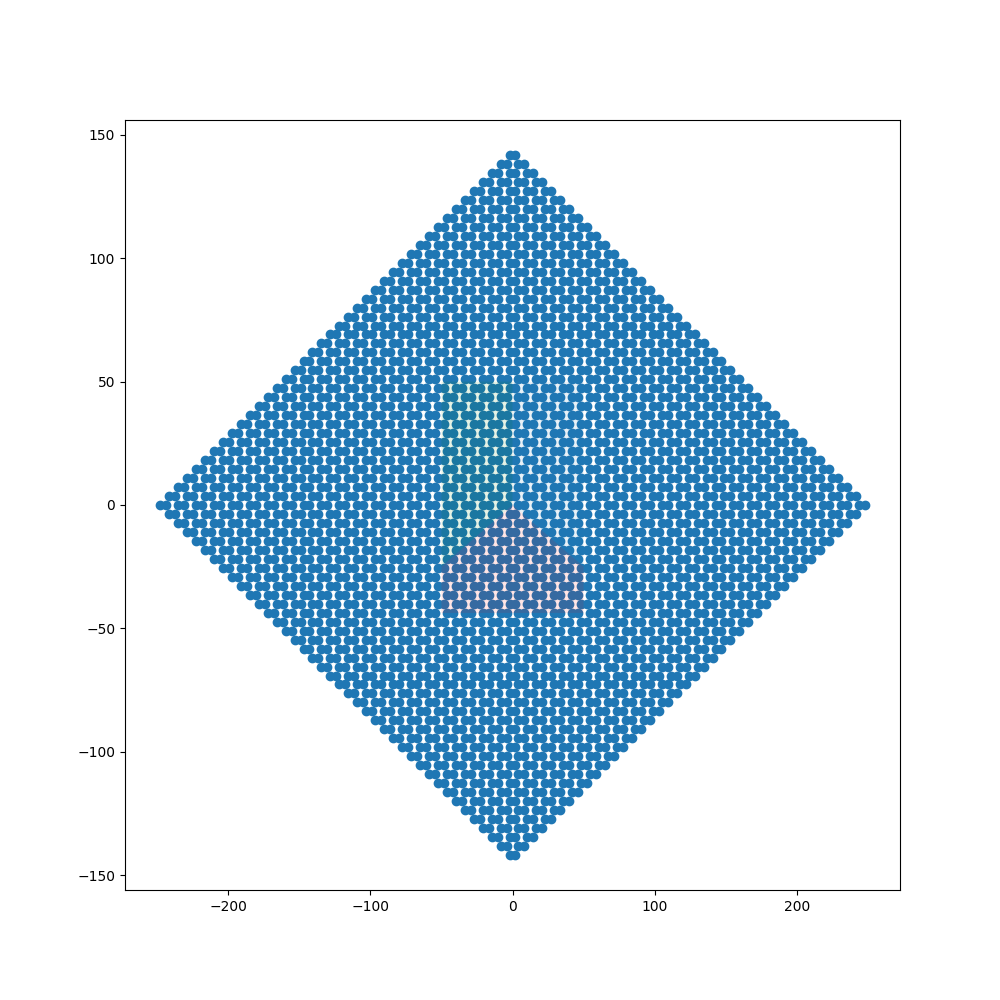

In [20]:
fig_lattice = plt.figure(figsize=(10,10))
ax_lattice = fig_lattice.add_subplot(111)

ax_lattice.scatter(b_10_list[:,0], b_10_list[:,1])
a_s, b_s, c_s = ABC_sections(50)
ax_lattice.add_patch(a_s)
ax_lattice.add_patch(b_s)
ax_lattice.add_patch(c_s)

plt.show()

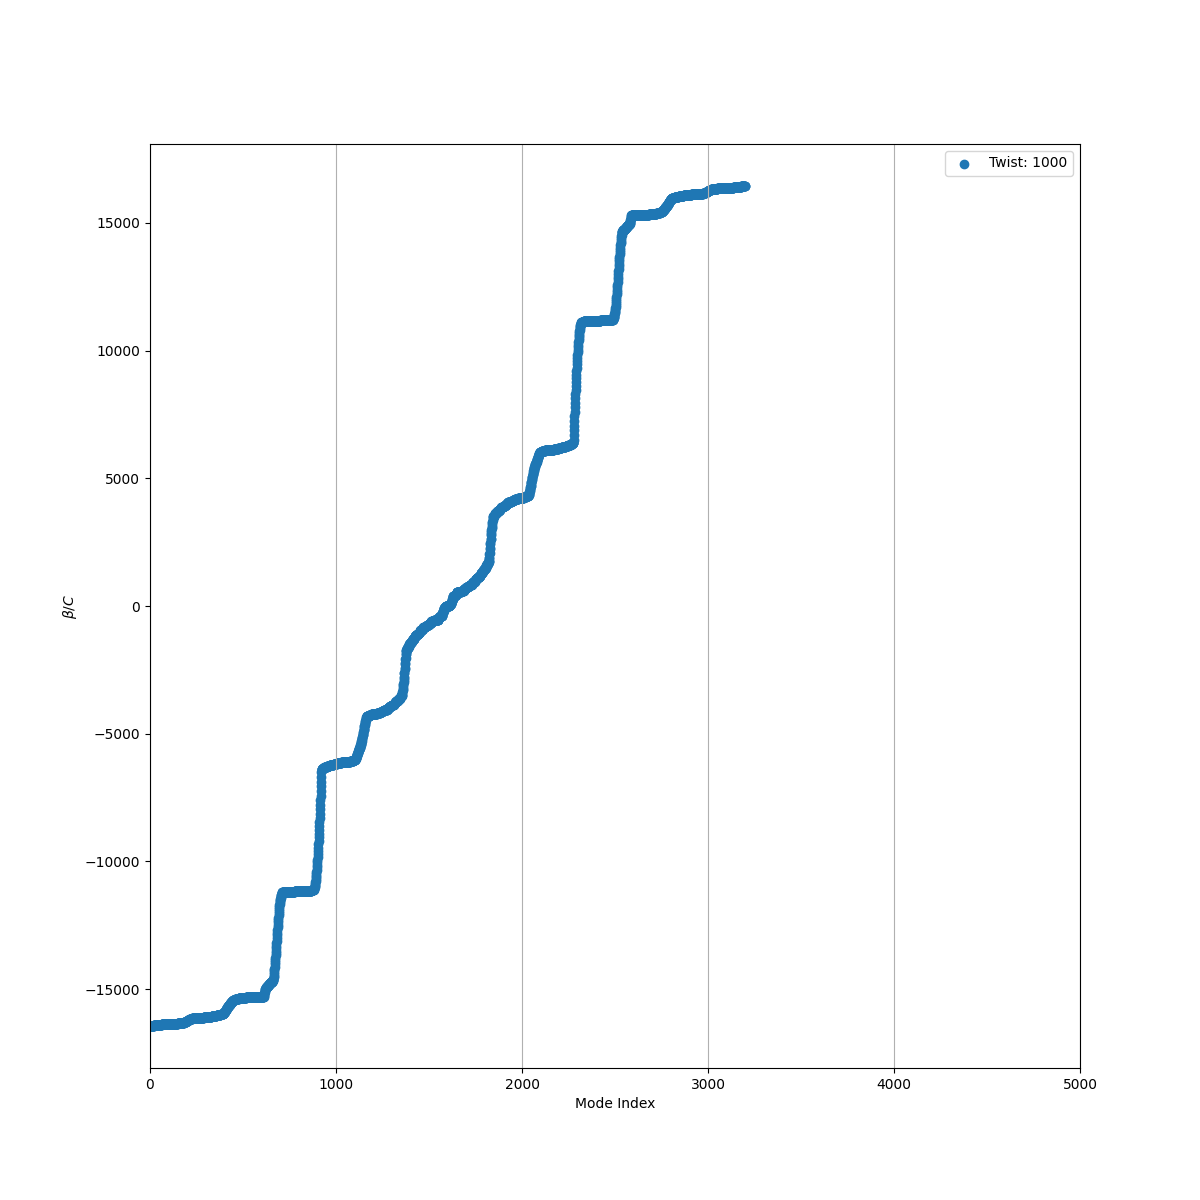

In [25]:
# beta_100 = beta_super
#print(eigvecs)
# print(beta_super)
# beta_vals_10, beta_vecs_10 = find_eigvalues(b_10_list, 4.5, 2*coupling, beta_0, 10)
# beta_vals_20, beta_vecs_20 = find_eigvalues(b_10_list, 4.5, 3*coupling, beta_0, 0)
# beta_vals_30 = find_eigvalues(b_10_list, 3.0, coupling, beta_0, 10)
# beta_vals_40 = find_eigvalues(b_10_list, 2.5, coupling, beta_0, 10)


beta_vals_1, beta_vecs_1 = find_eigvalues(b_10_list, 4.2, 6700, 5876619.5, 5000, with_onsite=False)
plot_betas(beta_vals_1, 6700,'Twist: 1000', xrange=[0,5000])

In [29]:
# First I build up the projector matrix for the desired band
def check_symmetric(a, rtol=1e-05, atol=1e-08):
    return np.allclose(a, a.T, rtol=rtol, atol=atol)

def real_space_chern_calc(beta_vals, beta_vecs, band_top):
    band_range = np.arange(0,band_top)
    # individual_matrix_list = np.zeros((len(beta_vecs), len(beta_vecs), len(band_range)), dtype=np.complex128)
    # print(np.shape(individual_matrix_list))
    # for point in band_range:
        # individual_matrix_list[:,:,point] = np.outer(beta_vecs[point],np.conjugate(beta_vecs[point]))
    # projector_matrix_orig = np.sum(individual_matrix_list, axis=2)   
    # print(np.shape(beta_vecs))
    projector_matrix = np.einsum('ni,nj-> ij', beta_vecs[:band_top], np.conjugate(beta_vecs[:band_top]))

    # Next I collect points in A,B,C sections
    a_indices, b_indices, c_indices = index_in_sections(b_10_list, 50)

    # Finally I find the overlap of the projector with all combinations of points 


    print(check_symmetric(projector_matrix))

    all_h_vals = np.zeros((len(a_indices), len(b_indices), len(c_indices)), dtype=np.complex128)

    for na,a_index in enumerate(a_indices):
        for nb,b_index in enumerate(b_indices):
            for nc,c_index in enumerate(c_indices):
                all_h_vals[na, nb, nc] = 12*np.pi*1.0j*(projector_matrix[a_index,b_index]*projector_matrix[b_index, c_index]*projector_matrix[c_index,a_index] - 
                                                        projector_matrix[a_index,c_index]*projector_matrix[c_index, b_index]*projector_matrix[b_index,a_index])
                                                        #h_i_j_k(a_index, b_index, c_index, projector_matrix)
    # print(projector_matrix[a_indices,b_indices])                           

    chern_no = np.sum(all_h_vals)
    return chern_no


False


(-0.003948376708239527+1.819208879469958e-16j)

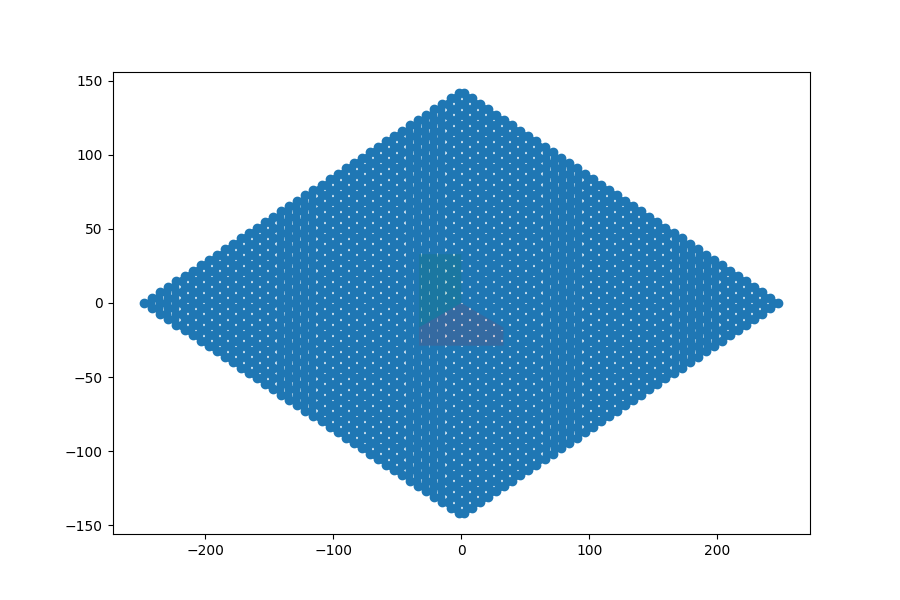

In [26]:
real_space_chern_calc(beta_vals_1, beta_vecs_1, 875)

1800


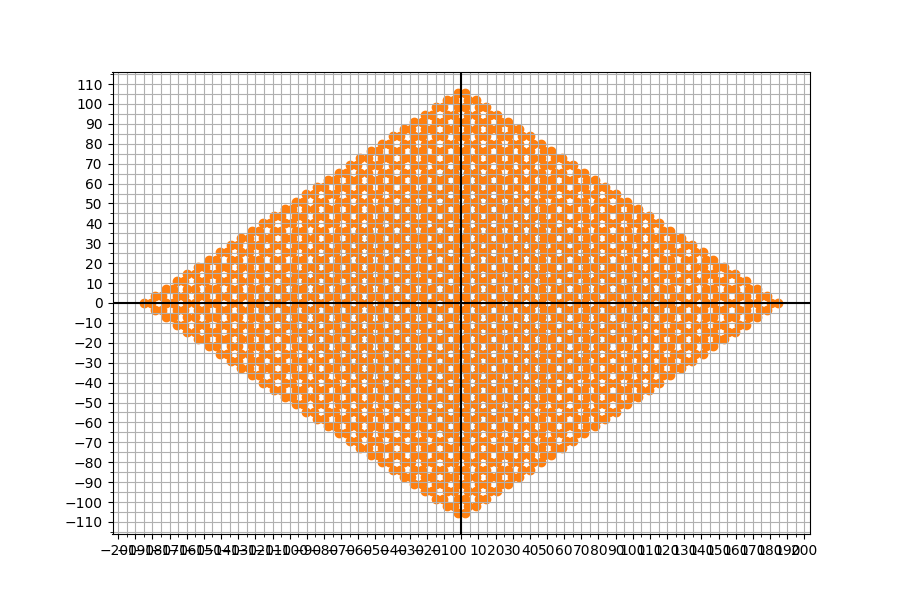

In [21]:
b_10_list = build_honeycomb(30,30, PITCH)
# plt.scatter(b_10_list[:,0], b_10_list[:,1]);   
# plt.scatter(b_10_list[:,0]-11.5*PITCH, b_10_list[:,1]-np.sqrt(3)*PITCH/2); 
plt.close()
plt.axhline(0, color='black')
plt.axvline(0, color='black')



plt.scatter(b_10_list[:,0], b_10_list[:,1]); 
# plt.scatter(b_10_list[:10,0], b_10_list[:10,1]);
# plt.scatter(b_10_list[10,0], b_10_list[10,1]);
# plt.scatter(b_10_list[20,0], b_10_list[20,1]);
print(len(b_10_list))
plt.show()

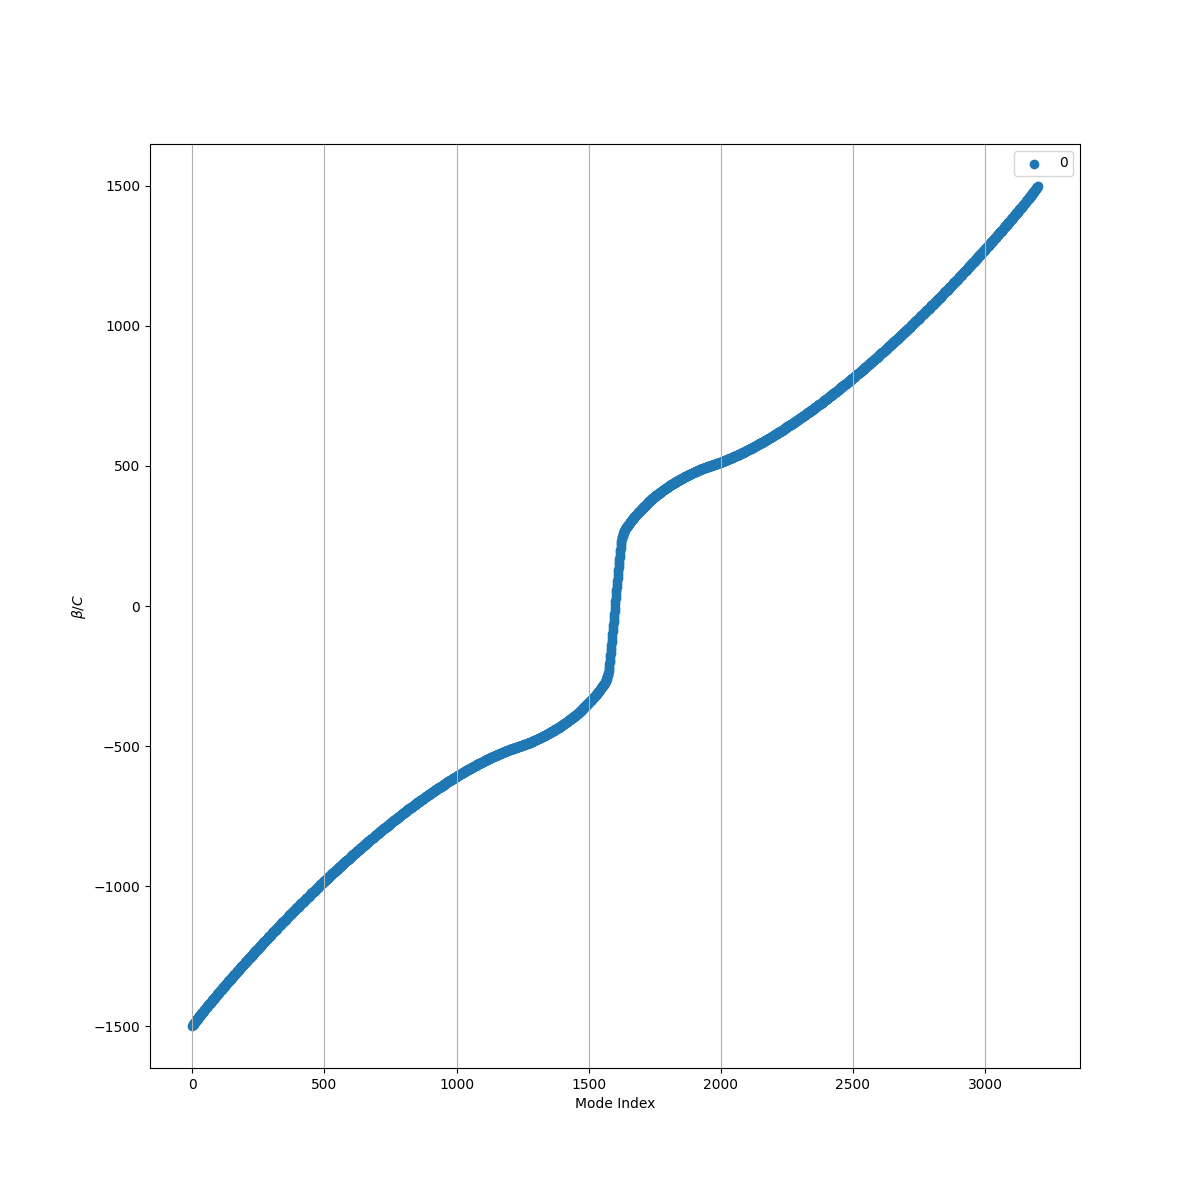

In [34]:
# haldane_vals, haldane_vecs = find_eigvalues_haldane(b_10_list, 4.2, 50, 0, 0.0, with_onsite=False)
# haldane_vals_2, haldane_vecs = find_eigvalues_haldane(b_10_list, 4.2, 50, 8, 0.0, with_onsite=False)
# haldane_vals_3, haldane_vecs = find_eigvalues_haldane(b_10_list, 4.2, 50, 16, 0.0, with_onsite=False)
haldane_vals_4, haldane_vecs = find_eigvalues_haldane(b_10_list, 4.2, 500, 54, 0.0, with_onsite=False)
plot_betas([haldane_vals_4], 10, ['0', '8', '16' ,'24'])
# print(b_10_list)

False


(0.17403281295130854-1.3210252973644936e-17j)

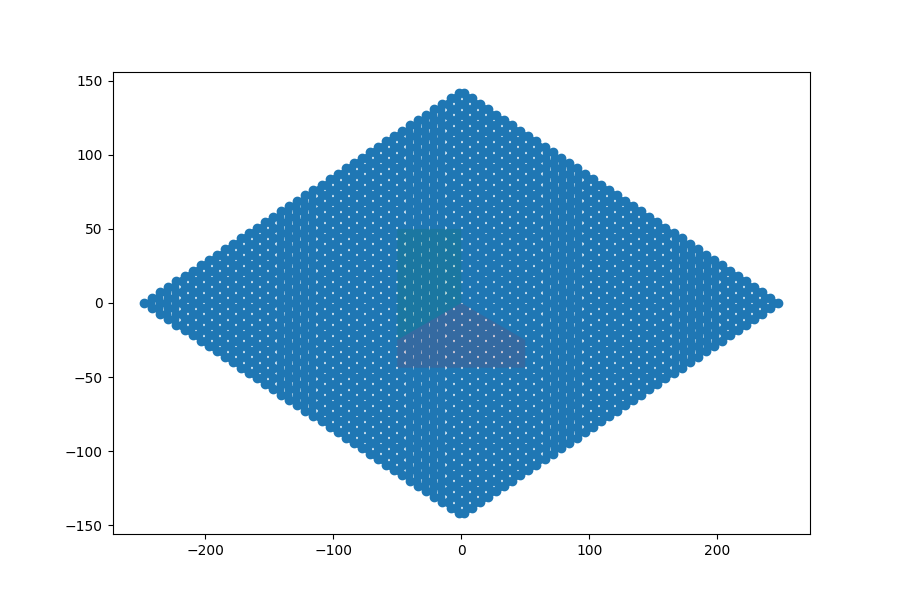

In [35]:
real_space_chern_calc(haldane_vals_4, haldane_vecs, 1573)
# print(np.shape(haldane_vecs[:606][0]))

In [ ]:
def build_and_find_eigs(n,m, pitch, c, beta_straight, twist, onsite=True):
    point_list = build_honeycomb(n,m,pitch)
    eigvals, eigvecs = find_eigvalues(point_list, pitch, c, beta_straight, twist, with_onsite=onsite)
    return eigvals, eigvecs
   

In [ ]:
beta_vals_sweep_1, beta_vecs_sweep_1 = build_and_find_eigs(7, 7, 4, 200, beta_0, 1000, True)
beta_vals_sweep_2, beta_vecs_sweep_2 = build_and_find_eigs(7, 7, 4, 500, beta_0, 1000, True)
beta_vals_sweep_3, beta_vecs_sweep_3 = build_and_find_eigs(7, 7, 4, 1000, beta_0, 1000, True)
beta_vals_sweep_4, beta_vecs_sweep_4 = build_and_find_eigs(7, 7, 4.2, 7000, beta_0, 900, True)
plot_betas([beta_vals_sweep_1, beta_vals_sweep_2, beta_vals_sweep_3, beta_vals_sweep_4], 191,[r'Coupling: $\alpha$', r'Coupling: 5$\alpha$', r'Coupling: 10$\alpha$', r'Coupling: 20$\alpha$'])

In [ ]:
vec_intensities_sweep = np.conjugate(beta_vecs_sweep_4)*beta_vecs_sweep_4
point_list = build_honeycomb(7, 7, 4.2)

for i in range(100):
    plot_coloured_chain(vec_intensities_sweep[:,i], 4, point_list, i);

In [ ]:
beta_vals_onsite_low, beta_vecs_onsite_low = find_eigvalues(b_10_list, 4.5, 3*coupling, beta_0, 50)
plot_betas(beta_vals_onsite_low, 3*coupling)

In [ ]:

vec_intensities_onsite_low = np.conjugate(beta_vecs_onsite_low)*beta_vecs_onsite_low

for i in range(3000,3050):
    plot_coloured_chain(vec_intensities_onsite_low[:,i], 3, b_10_list,i);

In [ ]:
vec_pot_list = []

for n in range(100):
    mid_point = (b_10_list[0,:] + b_10_list[n,:])/2
    a_dist = (b_10_list[0,:] - b_10_list[n,:])*1.0e-6
    term = vec_potential(mid_point[0]*1.0e-6, mid_point[1]*1.0e-6, 1000, beta_0)
    vec_pot_list.append(np.exp(1.0j *np.dot(term, a_dist)))

In [ ]:
plt.plot(np.arange(len(vec_pot_list)), vec_pot_list);
# plt.axhline(1.0, color='black');
# plt.axvline(272,color='red');

In [ ]:
print(vec_pot_list[265:275])

In [ ]:
vec_pot_list_2 = []

for m in range(59):
    mid_point = (b_10_list[0,:] + b_10_list[(m+1)*60,:])/2
    a_dist = (b_10_list[0,:] - b_10_list[(m+1)*60,:])*1.0e-6
    term = vec_potential(mid_point[0]*1.0e-6, mid_point[1]*1.0e-6, 20, beta_0)
    vec_pot_list_2.append(np.exp(1.0j *np.dot(term, a_dist)))

In [ ]:
plt.plot(np.arange(len(vec_pot_list_2)), vec_pot_list_2);
# plt.axhline(1.0, color='black');
# plt.axvline(272,color='red');

Selecting only a hexagon around the origin to look at overall gamma change 

In [ ]:
pos = []

fig_hex = plt.figure(figsize=(9,6))
ax_hex = fig_hex.add_subplot(111)

ax_hex.scatter(b_10_list[:,0], b_10_list[:,1], cmap='Reds')
ax_hex.xaxis.set_major_locator(MultipleLocator(10))
ax_hex.xaxis.set_minor_locator(MultipleLocator(5))
ax_hex.yaxis.set_major_locator(MultipleLocator(10))
ax_hex.yaxis.set_minor_locator(MultipleLocator(5))
#ax1.xaxis.set_major_formatter({x:.0f})
plt.grid(which='both')

fig_hex.canvas.mpl_connect('button_press_event', onclick)
plt.show()

In [ ]:


pos = np.array(pos)
points_to_keep = np.where(cdist(b_10_list, pos, 'euclidean')>2, False, True )
index_to_keep = np.any(points_to_keep, axis=1)
selected_hexagon = b_10_list[index_to_keep]
# [print(type(i)) for i in pos]
col_list = ['red', 'green', 'black', 'blue', 'yellow', 'brown']
for i in range(6):
    plt.scatter(selected_hexagon[i,0], selected_hexagon[i,1], color=col_list[i]);

In [ ]:
alist = []
phase_list = []

for coord in enumerate(selected_hexagon):
    alist.append(vec_potential(coord[0]*1.0e-6, coord[1]*1.0e-6, 20, beta_0))

r1_2 = selected_hexagon[2] - selected_hexagon[4] # yellow to black
r2_3 = selected_hexagon[5] - selected_hexagon[2] # black to brown
r3_4 = selected_hexagon[1] - selected_hexagon[5] # brown to green
r4_5 = selected_hexagon[3] - selected_hexagon[1] # green to blue
r5_6 = selected_hexagon[0] - selected_hexagon[3] # blue to red
r6_1 = selected_hexagon[4] - selected_hexagon[0] # red to yellow 

r_list = [r6_1, r4_5, r2_3, r5_6, r1_2, r3_4]
phase_list = np.array([1,-1,1,-1,1,-1])

for n in range(len(r_list)):
    sum_list = phase_list[n]*np.dot(r_list[n]*1.0e-6,alist[n])

print(sum(sum_list))

That kind of looks like nonsense. I will do the square case and verify it all works 

In [ ]:
print(np.shape(beta_vecs_pen))
gsp = np.zeros((len(beta_vecs_pen), len(beta_vecs_pen), len(beta_vecs_pen)), dtype=np.complex128)

for i in range(len(gsp[0,:])):
    gsp[:,:,i] = np.outer(beta_vecs_pen[:,i], beta_vecs_pen[:,i])

print(np.sum(gsp, axis=2))

Measuring the penetration depth of an edge mode

In [ ]:
beta_vals_pen, beta_vecs_pen = build_and_find_eigs(10, 10, 4.2, 5000, 5876619, 300, False)

In [ ]:
plot_betas(beta_vals_pen, 6700, '')

In [ ]:
vec_intensities_pen = np.conjugate(beta_vecs_pen)*beta_vecs_pen
point_list = build_honeycomb(25, 25, 4.2)
# find_eigvalues(point_list, 4.2, 5000, 5876619.5, 300)
for i in range(400, 625):
    plot_coloured_chain(vec_intensities_pen[:,i], 4.2, point_list, i);

In [ ]:
%matplotlib
pos = []

fig_pen_depth = plt.figure(figsize=(9,6))
ax_pen_depth = fig_pen_depth.add_subplot(111)

ax_pen_depth.scatter(point_list[:,0], point_list[:,1], cmap='Reds')
ax_pen_depth.xaxis.set_major_locator(MultipleLocator(10))
ax_pen_depth.xaxis.set_minor_locator(MultipleLocator(5))
ax_pen_depth.yaxis.set_major_locator(MultipleLocator(10))
ax_pen_depth.yaxis.set_minor_locator(MultipleLocator(5))
#ax1.xaxis.set_major_formatter({x:.0f})
plt.grid(which='both')

fig_pen_depth.canvas.mpl_connect('button_press_event', onclick)
plt.show()


In [ ]:

pos = np.array(pos)
points_to_keep = np.where(cdist(point_list, pos, 'euclidean')>2, False, True )
penetration_indices = np.any(points_to_keep, axis=1)
selected_cores = point_list[penetration_indices]
plt.scatter(selected_cores[:,0], selected_cores[:,1]);
plt.axes().set_aspect('equal');


In [ ]:
# print(beta_vecs_pen[:,44])
# print(vec_intensities_pen[penetration_indices,])

In [ ]:
# twist_1000_edge_list = vec_intensities_pen[penetration_indices, 595]
# twist_2000_edge_list = vec_intensities_pen[penetration_indices, 347]
# twist_3000_edge_list = vec_intensities_pen[penetration_indices, 341]
# twist_4000_edge_list = vec_intensities_pen[penetration_indices, 335]
# twist_5000_edge_list = vec_intensities_pen[penetration_indices, 328]

# twist_edges = np.zeros((10,len(vec_intensities_pen[penetration_indices, 0])))
# for n,i in enumerate(range(595,605)):
#     twist_edges[n,:] = vec_intensities_pen[penetration_indices, i]

# twist_edge_mean_6 = np.mean(twist_edges, axis=0)
# print(twist_edge_mean)
# twisted_edge_lists = [twist_1000_edge_list, twist_2000_edge_list, twist_3000_edge_list, twist_4000_edge_list, twist_5000_edge_list]
# twisted_edge_lists = [twist_edge_mean_1, twist_edge_mean_2, twist_edge_mean_3, twist_edge_mean_4, twist_edge_mean_5,
                    #   twist_edge_mean_6]#, twist_edge_mean_7, twist_edge_mean_8, twist_edge_mean_9, twist_edge_mean_10]


In [ ]:
print(twist_edge_mean_1)

In [ ]:
import scipy.optimize as sciop

In [ ]:
def exp_func(x,a,b):
    return a*np.exp(b*x)

def exp_squared_func(x, a, b):
    return a*np.exp(b*x**2)

def square_root(x, a):
    return a/np.sqrt(x)

    
def over_x(x, a):
    return a/x

In [ ]:
mag_list = np.zeros(len(twisted_edge_lists))
# print(mag_list)
for n, elist in enumerate(twisted_edge_lists):
    popt, pcov = sciop.curve_fit(exp_func, np.arange(len(elist)), elist)
    popt_squared, pcov_squared = sciop.curve_fit(exp_squared_func, np.arange(len(elist)), elist)
    print(popt[1])
    mag_length = 1/popt[1]
    mag_list[n] = mag_length

# popt, pcov = sciop.curve_fit(exp_func, np.arange(len(twist_edge_mean_1)), twist_edge_mean_1)
# x_step = np.arange(0,12,0.01)
# y_vals = popt[0]*np.exp(popt[1]*x_step)
# y_vals_squared = popt_squared[0]*np.exp(popt_squared[1]*x_step)

In [ ]:
fig_intensities = plt.figure(figsize=(10,8))
ax_intensities = fig_intensities.add_subplot(111)

# for k, n in enumerate(twisted_edge_lists):
    # ax_intensities.plot(np.arange(len(n)),n, label=k)

ax_intensities.scatter(np.arange(len(twist_edge_mean_1)), twist_edge_mean_1)
ax_intensities.plot(x_step, y_vals) 
# ax_intensities.plot(x_step, y_vals_squared) 
# ax_intensities.set_yscale('log')
plt.legend()

In [ ]:
fig_mag_length = plt.figure(figsize=(10,8))
ax_mag_length = fig_mag_length.add_subplot(111)
twist_list = [300, 280, 260, 240, 220, 200]

sqrt_popt, sqrt_pcov = sciop.curve_fit(square_root, twist_list, mag_list)
over_popt, over_pcov = sciop.curve_fit(over_x, twist_list, mag_list)
sqrt_xlist = np.arange(np.min(twist_list), np.max(twist_list),1)
sqrt_ylist = sqrt_popt[0]/np.sqrt(sqrt_xlist)
over_ylist = over_popt[0]/sqrt_xlist


ax_mag_length.scatter(twist_list, mag_list)
ax_mag_length.plot(sqrt_xlist, sqrt_ylist, label='y = {:.4f}/sqrt(x)'.format(popt[0]))
ax_mag_length.plot(sqrt_xlist, over_ylist, label='y = {:.2f}/x'.format(over_popt[0]))
ax_mag_length.set_ylabel('Magnetic Length l')
ax_mag_length.set_xlabel(r'Twist rate $\alpha$')
plt.legend()
plt.show()

(4, 2)
A contains:
 [0 1 2 3]
B contains:
 [5]
C contains:
 [0 6]


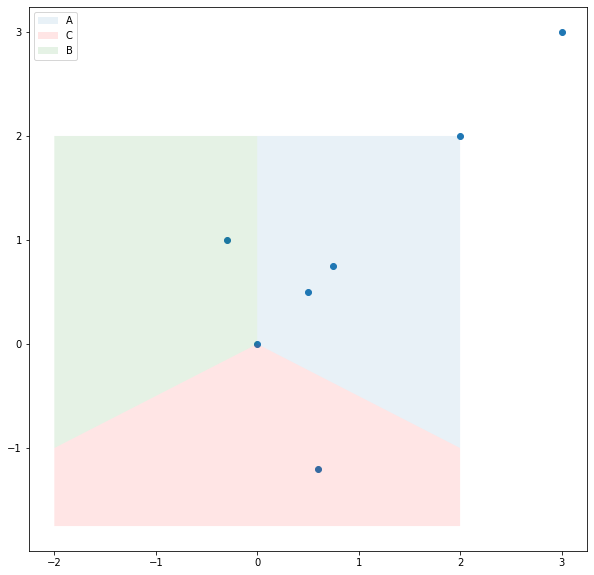

In [152]:
fig_circ = plt.figure(figsize=(10,10))
ax_circ = fig_circ.add_subplot(111)
xyA = np.array([[0,0], [2,-1], [2,2], [0,2]])
xyC = np.array([[0,0],[2,-1],[2, -1.75], [-2,-1.75],[-2,-1]])
xyB = np.array([[0,0], [-2,-1], [-2,2], [0,2]])
print(np.shape(xyA))
test_circ_A = patches.Polygon(xyA,alpha=0.1, label='A')
test_circ_C = patches.Polygon(xyC,fc='red', alpha=0.1, label='C')
test_circ_B = patches.Polygon(xyB,fc='green', alpha=0.1, label='B')
points_test = np.array([[0,0],[0.5,0.5], [0.75,0.75],[2,2],[3,3],[-0.3,1],[0.6, -1.2]])
ax_circ.scatter(points_test[:,0], points_test[:,1])
ax_circ.add_patch(test_circ_A)
ax_circ.add_patch(test_circ_C)
ax_circ.add_patch(test_circ_B)

Acont = test_circ_A.contains_points(ax_circ.transData.transform(points_test)).nonzero()[0]
Bcont = test_circ_B.contains_points(ax_circ.transData.transform(points_test)).nonzero()[0]
Ccont = test_circ_C.contains_points(ax_circ.transData.transform(points_test)).nonzero()[0]
print('A contains:\n '+str(Acont))
print('B contains:\n '+str(Bcont))
print('C contains:\n '+str(Ccont))

plt.legend()
plt.show()



    


In [57]:
a_test = np.array([[0,1,2,3,4],[2,2,2,2,2],[0,0,0,0,0]])
b_test = np.array([[1,1,1,1,1], [3,3,3,3,0],[4,4,4,4,0]])

print(np.outer(a_test[0], b_test[0]))

print(np.einsum('ni,nj-> ij', a_test, b_test))
print(np.sum(np.einsum('ni,nj-> nij', a_test, b_test), axis=0))

[[0 0 0 0 0]
 [1 1 1 1 1]
 [2 2 2 2 2]
 [3 3 3 3 3]
 [4 4 4 4 4]]
[[ 6  6  6  6  0]
 [ 7  7  7  7  1]
 [ 8  8  8  8  2]
 [ 9  9  9  9  3]
 [10 10 10 10  4]]
[[ 6  6  6  6  0]
 [ 7  7  7  7  1]
 [ 8  8  8  8  2]
 [ 9  9  9  9  3]
 [10 10 10 10  4]]
